## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [1]:
import string
import os

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [2]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/master/homeworks_basic/Lab2_DL/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [3]:
text = "".join(text).lower()

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


### Data loading: "Евгений Онегин"


In [75]:
!wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
    
with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()
    
text = [x.replace('\t\t', '') for x in text]

^C


FileNotFoundError: [Errno 2] No such file or directory: 'onegin.txt'

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [ ]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here


Put all the characters, that you've seen in the text, into variable `tokens`.

In [4]:
tokens = sorted(set(text))
tokens.append('<') # <SOS>
tokens.append('>') # <EOS>
tokens.append('_') # <PAD>

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [5]:
token_to_idx = {token: idx for idx, token in enumerate(tokens)}
idx_to_token = tokens

In [6]:
# Delete exsessive gaps and split to quatrains
lines = ''.join(text.split('\n\n')[::2]).split("\n")
lines = [line[2:] for line in lines]
#quatrains = ['\n'.join(lines[i:i+4]) for i in range(len(lines) // 4)]
quatrains = ['\n'.join(lines[i:i+4]) for i in range(len(lines) - 4)]
MAX_LENGTH = max(map(len, quatrains))
num_tokens = len(tokens)

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

###### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [7]:
from random import sample
def to_matrix(
    quatrains, max_len=None, pad=token_to_idx['_'], dtype='int32', batch_first=True
    ):
    """Casts a list of quatrains into rnn-digestable matrix"""
    
    if isinstance(quatrains, list):
        max_len = max_len or max(map(len, quatrains))
    else:
        max_len = len(quatrains)
    max_len += 1
    
    max_iter = len(quatrains) if isinstance(quatrains, list) else 1
    /
    quatrains_ix = np.zeros([max_iter, max_len], dtype) + pad
    quatrains_ix[:, 0] = token_to_idx['<'] # 
    
    
    for i in range(max_iter):
        line_ix = [token_to_idx[c] for c in quatrains[i]] if isinstance(quatrains, list) else [token_to_idx[c] for c in quatrains]
        quatrains_ix[i, 1:len(line_ix)] = line_ix[1:]
        quatrains_ix[i, len(line_ix)] = token_to_idx['>'] 

    if not batch_first: # convert [batch, time] into [time, batch]
        quatrains_ix = np.transpose(quatrains_ix)

    return quatrains_ix

In [8]:
import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
from IPython.display import clear_output
import seaborn as sns
sns.set_theme(style='darkgrid')

class CharRNN(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=16, hidden_size=128):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.RNN(emb_size, hidden_size, batch_first=True,
                         nonlinearity='relu')
        self.hid_to_logits = nn.Linear(hidden_size, num_tokens)
        self.hidden_size = hidden_size
        
    def forward(self, x):
        assert isinstance(x.data, torch.LongTensor)
        out, hid_state = self.rnn(self.emb(x))
        next_logits = self.hid_to_logits(out)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp
    
    def generate(self, x, hid_state):
        out, hid_state = self.rnn(self.emb(x), hid_state)
        next_logits = self.hid_to_logits(out)
        return next_logits, hid_state

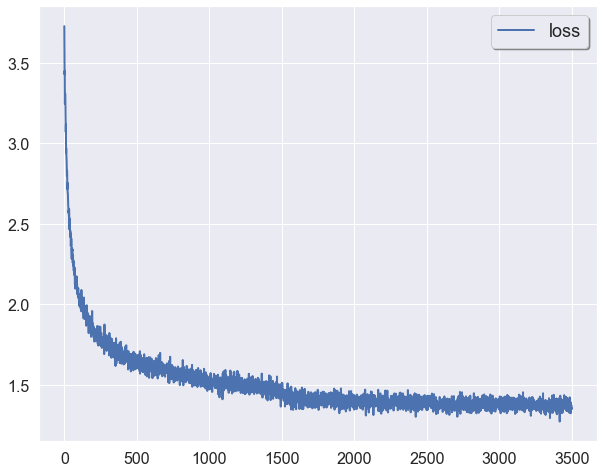

In [10]:
loss_history = []

try:
    del model
except:
    pass 

model = CharRNN()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, 
                                milestones=[1500, 2500], gamma=0.1)

for i in range(3500):
    batch_ix = to_matrix(sample(quatrains, 16), max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    logp_seq = model(batch_ix)

    loss = F.nll_loss(logp_seq[:, :-1].contiguous().view(-1, num_tokens), 
                  batch_ix[:, 1:].contiguous().view(-1), 
                      ignore_index=token_to_idx['_'])
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

    loss_history.append(loss.data.numpy())
    if (i+1)%100 == 0:
        plt.figure(figsize=(10,8))
        clear_output(True)
        plt.plot(loss_history, lw=2, label='loss')
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.legend(shadow=True, fontsize=18)
        plt.show()

Plot the loss function (axis X: number of epochs, axis Y: loss function).

In [11]:
# Your plot code here

In [12]:
def generate_sample(model, seed_phrase='<th', max_length=MAX_LENGTH*2, temperature=1.0):
    '''
    ### Disclaimer: this is an example function for text generation.
    ### You can either adapt it in your code or create your own function
    
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs, 
        smaller temperature converges to the single most likely output.
        
    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''
    
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = torch.zeros(1, model.hidden_size, requires_grad=True)
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        logits, hid_state = model.generate(x_sequence[:, i], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):

        logits, hid_state = model.generate(x_sequence[:, -1], hid_state)
        # Be really careful here with the model output
        p_next = F.softmax(logits / temperature, dim=-1).data.numpy()[0]
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        
        if next_ix == token_to_idx['>']:
            break
            
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
    
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [13]:
print(generate_sample(model, temperature=0.4)[1:])

thence still and heart which thy shall give the world and you with the sweet self in the world's sweet self to be thy self my heart thou dost his still,
  that i am all my beauty of the world my sen the beauty of thine old with my love no loss,
or thee what worthing thee my new to me to thee in the take thee in the blame the old dear injuries the worst of blame shall be dear love, and the praise thou that she with me with for thee in the strange of thine abuse thee are and the world whileress and t


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [14]:
class LSTM(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=32, hidden_size=128):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.lstm = nn.LSTM(emb_size, hidden_size, batch_first=True)
        self.hid_to_logits = nn.Linear(hidden_size, num_tokens)
        self.hidden_size = hidden_size
        
    def forward(self, x):
        assert isinstance(x.data, torch.LongTensor)
        out, hc_n  = self.lstm(self.emb(x))
        h_n, c_n = hc_n[0], hc_n[1]
        next_logits = self.hid_to_logits(out)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp
    
    def generate(self, x, h_0, c_0):
        out, hc_n = self.lstm(self.emb(x), (h_0, c_0))
        h_n, c_n = hc_n[0], hc_n[1]
        next_logits = self.hid_to_logits(out)
        return next_logits, h_n, c_n

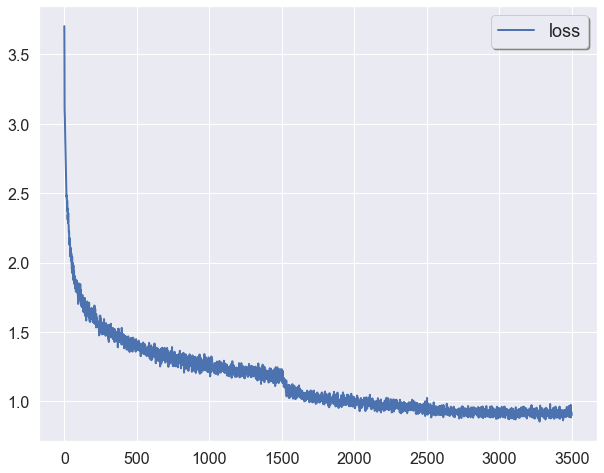

In [15]:
loss_history_lstm = []

try:
    del model_lstm
except:
    pass 

model_lstm = LSTM()
optimizer_lstm = torch.optim.Adam(model_lstm.parameters(), lr=1e-2)
scheduler_lstm = torch.optim.lr_scheduler.MultiStepLR(optimizer_lstm, 
                                milestones=[1500, 2500, 2501, 3000], gamma=0.2)

for i in range(3500):
    batch_ix = to_matrix(sample(quatrains, 16), max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    logp_seq = model_lstm(batch_ix)

    loss = F.nll_loss(logp_seq[:, :-1].contiguous().view(-1, num_tokens), 
                  batch_ix[:, 1:].contiguous().view(-1), 
                      ignore_index=token_to_idx['_'])
    
    optimizer_lstm.zero_grad()
    loss.backward()
    optimizer_lstm.step()
    scheduler_lstm.step()

    loss_history_lstm.append(loss.data.numpy())
    if (i+1)%100 == 0:
        plt.figure(figsize=(10,8))
        clear_output(True)
        plt.plot(loss_history_lstm, lw=2, label='loss')
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.legend(shadow=True, fontsize=18)
        plt.show()

In [16]:
def generate_sample_lstm(model, seed_phrase='<the', max_length=MAX_LENGTH*2, temperature=1.0):
    
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    h_n = torch.zeros(1, model.hidden_size, requires_grad=True)
    c_n = torch.zeros(1, model.hidden_size, requires_grad=True)
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        logits, h_n, c_n = model.generate(x_sequence[:, i], h_n, c_n)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):

        logits, h_n, c_n = model.generate(x_sequence[:, -1], h_n, c_n)
        # Be really careful here with the model output
        p_next = F.softmax(logits / temperature, dim=-1).data.numpy()[0]
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        
        if next_ix == token_to_idx['>']:
            break
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [17]:
print(generate_sample_lstm(model_lstm, temperature=0.2)[1:])

thence your grows would contend.
  then thou art the world doth sing:
  since my mind, and in my self deceased that thou wilt thou art the world and there is my love, that i am thy self thou art as the world are more to shall i am so fortune of thee in the world all the world doth sight,
and so should thee that i have sweet form of thee that thou art the world and that receives reproves thee that thou art as the world and that which i be not to the world and then my love to thee,
  and therefore th


Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [20]:
lstm_01 = generate_sample_lstm(model_lstm, temperature=0.1)[1:]
lstm_02 = generate_sample_lstm(model_lstm, temperature=0.2)[1:]
lstm_05 = generate_sample_lstm(model_lstm, temperature=0.5)[1:]
lstm_1 = generate_sample_lstm(model_lstm, temperature=1.0)[1:]
lstm_2 = generate_sample_lstm(model_lstm, temperature=2.0)[1:]
generated = [lstm_01, lstm_02, lstm_05, lstm_1, lstm_2]
labels = ['0.1', '0.2', '0.5', '1.0', '2.0']

for i in range(5):
    print(f"    Temperature = {labels[i]}")
    print(generated[i])
    print()

    Temperature = 0.1
thence you made my love to thee,
when thou art the world and then my love to thee,
  and therefore thou art the world and there shall i am still thou art the world to be so thou shouldst in the world to be so thou shouldst in the world and there shall i am still thou art the world and there shall be thy self thou art the world and then my love to thee,
when thou art the world and then my love to thee,
when thou art the world and then my love to thee,
when thou art the world and then my love to thee

    Temperature = 0.2
thence your love, that is not from the world trifles trivel win one, and therefore to the world i not to the world and there shall i am still,
that i am thy self thou shalt fair where thou art the world and there my love to my dear love to show for this thou this thy self thou art the world and that which i see i can see thee i forgot lives seem'd thee words in the present'st thought, all those that which i see my deep doth my am thy self a moth'd

With temperature $\geqslant$ 1 generated output seems more and more chaotic that doesn't changes from run to run, temperature = 0.1, 0.2 provides us with readable samples which seems partly remembered from original text though. With temperature = 0.5 model generates smth between, don't quite know how to describe that. None of outputs actually seems like new original poesy, for which we would definetely need more complex approach taking words as a tokens, etc, but that could be a nice baseline -- we actually generating existing or seems to be existing words.

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [652]:
torch.save({
    'rnn_state_dict': model.state_dict(),
    'lstm_state_dict': model_lstm.state_dict(),
    'optimizer_rnn': optimizer.state_dict(),
    'optimizer_lstm': optimizer_lstm.state_dict(),
}, 'models.pt')

In [666]:
checkpoint = torch.load('models.pt')

rnn = CharRNN()
rnn.load_state_dict(checkpoint['rnn_state_dict'])
lstm = LSTM()
lstm.load_state_dict(checkpoint['lstm_state_dict'])

print('   RNN:\n', generate_sample(rnn, temperature=0.4)[1:], '\n', sep='')
print('   LSTM:\n', generate_sample_lstm(model_lstm, temperature=0.2)[1:], '\n', sep='')

   RNN:
ther her ble do whate's canden' u
dot ullest of mine, and be the plack'd rost thou grow'st,
  and all thy glast;
  so shall be a live's for leaves quite gone,
who ale and wils must before.
  to show;
not i forts,
which must live, and hath his night,
but draw no lines to thee liff's despisting:
thee,
kis fortunt a tomb with thy shape, not let fresh ghart, and meep to sevour a seaven
frime,
and thou art i love lombss'de hath provingred and he could atcing thy sins   as that best high due deam his par

   LSTM:
thered and thy bravery in their rotten smoke?
'tis not enough that through the cloud thou break,
to dry the rain on my storm-beaten face,
for no man well of such a salve can speak,
that heals the wound, and cures not the disgrace:
nor can thy shame give physic to my grief;
though thou repent, yet i have still the loss:
the offender's sorrow lends but weak relief
to him that bears the strong offence's cross.
  ah! but those tears are pearl which thy love sheds,
  and they ar

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)